# Poem Generation using FastAI


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install fastai


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.5 MB/s eta 0:00:00


## Import Libraries


In [5]:
# from fastbook import *
from fastai.text.all import *
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

In [6]:
pretrained_weights = 'gpt2'
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

In [7]:
path = '/content/drive/MyDrive/Colab Notebooks'

In [8]:
poems = get_text_files(path, folders = ['forms','topics'])
print("There are",len(poems),"poems in the dataset")

There are 7224 poems in the dataset


We'll start off with training the model on ballads. There are only 100 ballads so it won't take as long to train.

In [9]:
ballads = get_text_files(path+'/forms', folders = ['ballad'])
print("There are",len(ballads),"ballads in the dataset")

There are 100 ballads in the dataset


In [10]:
txt = poems[0].open().read(); #read the first file
print(txt)

Six monarch butterfly cocoons
clinging to the back of your throat—
you could feel their gold wings trembling.
You were alarmed. You felt infested.
In the downstairs bathroom of the family home,
gagging to spit them out—
and a voice saying Don't, don't—


## Prepare the Data



In [11]:
ballads = L(o.open().read() for o in ballads) # to make things easy we will gather all texts in one numpy array

In [12]:
def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt
  
all_ballads = flatten(ballads)

In [13]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [14]:
splits = [range_of(70), range(100)] # use a 70/30 split
tls = TfmdLists(all_ballads, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [15]:
show_at(tls.train, 0)

'A letter from my love to-day!
Oh, unexpected, dear appeal!'
She struck a happy tear away,
And broke the crimson seal.
'My love, there is no help on earth,
No help in heaven; the dead-man's bell
Must toll our wedding; our first hearth
Must be the well-paved floor of hell.'
The colour died from out her face,
Her eyes like ghostly candles shone;
She cast dread looks about the place,
Then clenched her teeth and read right on.
'I may not pass the prison door;
Here must I rot from day to day,
Unless I wed whom I abhor,
My cousin, Blanche of Valencay.
'At midnight with my dagger keen,
I'll take my life; it must be so.
Meet me in hell to-night, my queen,
For weal and woe.'
She laughed although her face was wan,
She girded on her golden belt,
She took her jewelled ivory fan,
And at her glowing missal knelt.
Then rose, 'And am I mad?' she said:
She broke her fan, her belt untied;
With leather girt herself instead,
And stuck a dagger at her side.
She waited, shuddering in her room,
Till sleep ha

In [16]:
bs,sl = 4,256
dls = tls.dataloaders(bs=bs, seq_len=sl)

Token indices sequence length is longer than the specified maximum sequence length for this model (1214 > 1024). Running this sequence through the model will result in indexing errors


In [17]:
dls.show_batch(max_n=2)

,text,text_
0,"The ring is on my hand,\nAnd the wreath is on my brow;\nSatin and jewels grand\nAre all at my command,\nAnd I am happy now.\nAnd my lord he loves me well;\nBut, when first he breathed his vow,\nI felt my bosom swell-\nFor the words rang as a knell,\nAnd the voice seemed his who fell\nIn the battle down the dell,\nAnd who is happy now.\nBut he spoke to re-assure me,\nAnd he kissed my pallid brow,\nWhile a reverie came o'er me,\nAnd to the church-yard bore me,\nAnd I sighed to him before me,\nThinking him dead D'Elormie,\n""Oh, I am happy now!""\nAnd thus the words were spoken,\nAnd this the plighted vow,\nAnd, though my faith be broken,\nAnd, though my heart be broken,\nHere is a ring, as token\nThat I am happy now!\nWould God I could awaken!\nFor I dream I know not how!\nAnd my soul is sorely shaken\nLest an evil step be taken,-\nLest the dead who is","ring is on my hand,\nAnd the wreath is on my brow;\nSatin and jewels grand\nAre all at my command,\nAnd I am happy now.\nAnd my lord he loves me well;\nBut, when first he breathed his vow,\nI felt my bosom swell-\nFor the words rang as a knell,\nAnd the voice seemed his who fell\nIn the battle down the dell,\nAnd who is happy now.\nBut he spoke to re-assure me,\nAnd he kissed my pallid brow,\nWhile a reverie came o'er me,\nAnd to the church-yard bore me,\nAnd I sighed to him before me,\nThinking him dead D'Elormie,\n""Oh, I am happy now!""\nAnd thus the words were spoken,\nAnd this the plighted vow,\nAnd, though my faith be broken,\nAnd, though my heart be broken,\nHere is a ring, as token\nThat I am happy now!\nWould God I could awaken!\nFor I dream I know not how!\nAnd my soul is sorely shaken\nLest an evil step be taken,-\nLest the dead who is fors"
1,"ly won\nHave ever to the sun\nBy Fame been raised!\n""And for myself,"" quoth he,\n""This my full rest shall be:\nEngland ne'er mourn for me,\nNor more esteem me;\nVictor I will remain,\nOr on this earth lie slain;\nNever shall she sustain\nLoss to redeem me!\n""Poitiers and Cressy tell\nWhen most their pride did swell\nUnder our swords they fell;\nNo less our skill is\nThan when our grandsire great,\nClaiming the regal seat,\nBy many a warlike feat\nLopp'd the French lilies.""\nThe Duke of York so dread\nThe eager vaward led;\nWith the main Henry sped\nAmongst his henchmen:\nExcester had the rear,\nA braver man not there\nO Lord, how hot they were\nOn the false Frenchmen!\nThey now to fight are gone;\nArmour on armour shone;\nDrum now to drum did groan:\nTo hear, was wonder;\nThat, with cries they make,\nThe very earth did shake;\nTrumpet to trumpet spake,\nThunder to thunder","won\nHave ever to the sun\nBy Fame been raised!\n""And for myself,"" quoth he,\n""This my full rest shall be:\nEngland ne'er mourn for me,\nNor more esteem me;\nVictor I will remain,\nOr on this earth lie slain;\nNever shall she sustain\nLoss to redeem me!\n""Poitiers and Cressy tell\nWhen most their pride did swell\nUnder our swords they fell;\nNo less our skill is\nThan when our grandsire great,\nClaiming the regal seat,\nBy many a warlike feat\nLopp'd the French lilies.""\nThe Duke of York so dread\nThe eager vaward led;\nWith the main Henry sped\nAmongst his henchmen:\nExcester had the rear,\nA braver man not there\nO Lord, how hot they were\nOn the false Frenchmen!\nThey now to fight are gone;\nArmour on armour shone;\nDrum now to drum did groan:\nTo hear, was wonder;\nThat, with cries they make,\nThe very earth did shake;\nTrumpet to trumpet spake,\nThunder to thunder."


## Fine-tuning the model

In [18]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [19]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [20]:
learn.validate()

(#2) [4.177581787109375,65.20797729492188]

SuggestedLRs(valley=0.0003311311302240938)

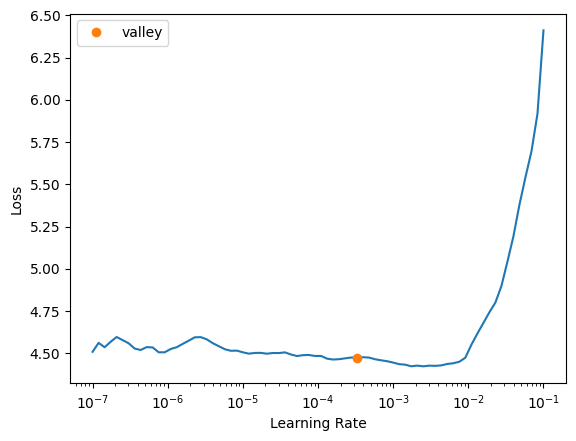

In [21]:
learn.lr_find()

In [22]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,4.330872,3.996684,54.417393,00:48


In [23]:
model.save_pretrained('/content/drive/My Drive/Colab Notebooks/Models3/')
tokenizer.save_pretrained('/content/drive/My Drive/Colab Notebooks/tokenizer/')

('/content/drive/My Drive/Colab Notebooks/tokenizer/tokenizer_config.json',
 '/content/drive/My Drive/Colab Notebooks/tokenizer/special_tokens_map.json',
 '/content/drive/My Drive/Colab Notebooks/tokenizer/vocab.json',
 '/content/drive/My Drive/Colab Notebooks/tokenizer/merges.txt',
 '/content/drive/My Drive/Colab Notebooks/tokenizer/added_tokens.json',
 '/content/drive/My Drive/Colab Notebooks/tokenizer/tokenizer.json')

## Poem Generation Example

In [24]:
prompt = 'i hate chocolat' # create an initial text prompt to start your generated text
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 5])

Adding the `num_beams` and `no_repeat_ngram_size` arguments make a huge difference. This can be explained [here](https://huggingface.co/blog/how-to-generate). Basically beam search reduces the risk of missing hidden high probability word sequences by keeping the most likely num_beams of hypotheses at each time step and eventually choosing the hypothesis that has the overall highest probability. Without beam search you will obtain a more greedy search. Beam search will always find an output sequence with higher probability than greedy search, but is not guaranteed to find the most likely output. Moreover, without the `no_repeat_ngram_size` you will likely obtain a repeated output. Thus we add a penalty that makes sure that no n-gram appears twice by manually setting the probability of next words that could create an already seen n-gram to 0.

In [25]:
preds = learn.model.generate(inp, max_length=60, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
i hate chocolaty,
And I love to eat it, and I hate to drink it.
I love it to the end of the day;
But I don't know what to do with it
When it comes to me, or when I go to bed.





In [26]:
prompt = "i hate chocolat "
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp,max_length=60, num_beams=5, no_repeat_ngram_size=2,do_sample = True, early_stopping=True)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
i hate chocolat!!!
I hate the taste of chocolate,
But I love the smell of sweet milk.
And I like the aroma of the grasshoppers
Like the leaves of a tree.


Oh, my God! I hate chocolate!
No, no,
